# Model Performance Metrics

Evaluate the model performance during and after training.

In [1]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

import sys

sys.path.insert(0, "..")
import plotting_utils
from plotting_utils import config
from tueplots import figsizes

config.experiment_name = "model-performance"
config.target = "nyu"
config.debug_mode = True

plt.rcParams.update(config.tueplots_bundle())

# Data Wrangling
import pandas as pd

# Machine Learning
import numpy as np
import torch
import torcheval

# Project 
from data.data_splitting import split_dataset_dfs
from models import get_fine_tuned_model
from data.car_dataset import (
    CarDataset,
    data_transforms,
    year2label_fn,label2year_fn
)


/opt/anaconda3/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/anaconda3/lib/python3.7/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <3224DED3-FCE0-3B10-9D68-9EC019B2AFEC> /opt/anaconda3/lib/python3.7/site-packages/torchvision/image.so
  Expected in:     <7EC12623-0CF1-3739-8CBB-242EFC29E2B3> /opt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


## Load Results

In [2]:
# Load results from file
train_test_result_batches = pd.read_csv(
    "../results/train_test_results_batches.csv", index_col=0
)
train_test_result_epochs = pd.read_csv(
    "../results/train_test_results_epochs.csv", index_col=0
)

In [3]:
train_test_result_epochs

,Epoch,Loss,Accuracy,Time,Phase
0,1,15.607089,0.1635,326.113266,Train
1,2,5.991505,0.1937,668.727997,Train
2,3,5.363469,0.1931,1011.376392,Train
3,4,3.629588,0.2207,1351.328991,Train
4,5,2.519359,0.2569,1694.988959,Train
5,6,2.044430,0.3037,2037.843195,Train
6,7,1.971500,0.3056,2385.021336,Train
7,8,1.984999,0.3080,2723.351573,Train
8,9,1.985540,0.3060,3066.634914,Train
9,10,1.986445,0.3030,3407.351750,Train


## Learning Curves

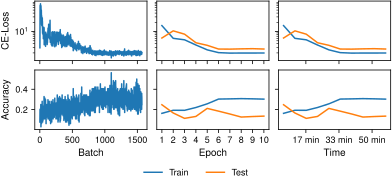

In [4]:
# Plot learning curves

with plt.rc_context(config.tueplots_bundle(rel_width=1.0, nrows=2, ncols=3)):
    fig, axs = plt.subplots(nrows=2, ncols=3, sharey="row", sharex="col")

    # Batch
    sns.lineplot(
        data=train_test_result_batches,
        x="Batch",
        y="Loss",
        hue="Phase",
        ax=axs[0, 0],
        legend=False,
    )
    sns.lineplot(
        data=train_test_result_batches,
        x="Batch",
        y="Accuracy",
        hue="Phase",
        ax=axs[1, 0],
        legend=False,
    )

    # Epoch
    sns.lineplot(
        data=train_test_result_epochs,
        x="Epoch",
        y="Loss",
        hue="Phase",
        ax=axs[0, 1],
        legend=True,
    )
    sns.lineplot(
        data=train_test_result_epochs,
        x="Epoch",
        y="Accuracy",
        hue="Phase",
        ax=axs[1, 1],
        legend=False,
    )

    # Time
    sns.lineplot(
        data=train_test_result_epochs,
        x="Time",
        y="Loss",
        hue="Phase",
        ax=axs[0, 2],
        legend=None,
    )
    sns.lineplot(
        data=train_test_result_epochs,
        x="Time",
        y="Accuracy",
        hue="Phase",
        ax=axs[1, 2],
        legend=False,
    )

    # Axis properties and labels
    axs[0, 0].set(ylabel="CE-Loss")
    axs[1, 0].set(ylabel="Accuracy")  # , ylim=[0, 1])

    fig.align_ylabels()

    for ax in axs[0]:
        ax.set(yscale="log", xlabel=None)

    # axs[1, 2].set_xscale("log")

    axs[0, 1].xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    axs[0, 2].xaxis.set_major_formatter(plotting_utils.tick_formatters.TimeFormatter())

    # Legend
    handles, labels = axs[0, 1].get_legend_handles_labels()
    fig.legend(
        handles=handles,
        labels=labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.0),
        fancybox=False,
        shadow=False,
        ncol=2,
        frameon=False,
    )
    axs[0, 1].get_legend().remove()

    plotting_utils.savefig(
        f"learning_curves",
        extension="pdf",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0.01,
    )

## Confusion Matrix

In [11]:
# Load test data
features_df = pd.read_csv("../../raw_data/tables/features.csv")
train_df, val_df, test_df = split_dataset_dfs("../../raw_data/tables/features.csv")

min_year = features_df["Launch_Year"].min()  # oldest car launch_year in data
max_year = features_df["Launch_Year"].max()
year_bucket_size = 2
year_range = max_year - min_year
num_year_classes = 1 + (year_range // year_bucket_size)  # floor division


# Random subset of test data set
torch.manual_seed(1)
test_subset_size = 1000
perm = torch.randperm(len(test_df))
idcs = perm[:test_subset_size].numpy()
dataset_test = CarDataset(
    features=test_df.iloc[idcs],
    transform=data_transforms["val"],
    year2label_fn=lambda year: year2label_fn(
        year, min_year=min_year, max_year=max_year, year_bucket_size=year_bucket_size
    ),
    img_root_dir="../../raw_data/",
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=len(dataset_test), shuffle=True
)

# Predict on test set
(
    inputs,
    _,
    _,
    _,
    _,
    year_labels,
    _,
) = next(iter(dataloader_test))

# Load trained model
model = get_fine_tuned_model(
    num_classes=num_year_classes, path_to_weights="../model_weights.pt"
)

In [12]:
from torcheval.metrics.functional import multiclass_confusion_matrix
from torch.nn.functional import softmax

with torch.no_grad():
    # Predict on test set
    outputs = softmax(model(inputs), dim=1)
    _, predictions = torch.max(outputs, 1)

    # Compute confusion matrix
    confusion_matrix = multiclass_confusion_matrix(
        predictions,
        year_labels,
        num_classes=num_year_classes,
        normalize="pred",  # Ensures predicted probabilities add to one per true year.
    )

In [13]:
confusion_matrix.shape

torch.Size([15, 15])

(array([  1.,   1.,   0.,  77.,  25., 174.,  70., 294., 119., 239.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

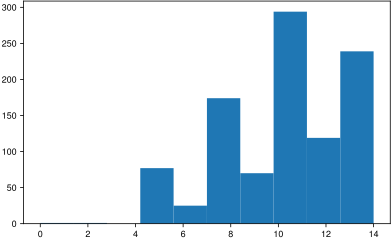

In [14]:
plt.hist(year_labels.numpy())

(array([  2.,   0.,  31.,  58., 131.,  87.,  51., 113., 419., 108.]),
 array([ 2. ,  3.2,  4.4,  5.6,  6.8,  8. ,  9.2, 10.4, 11.6, 12.8, 14. ]),
 <BarContainer object of 10 artists>)

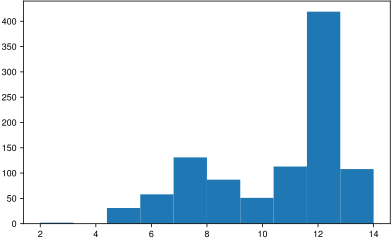

In [15]:
plt.hist(predictions.numpy())

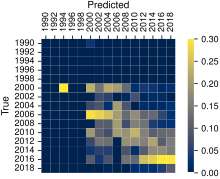

In [18]:
with plt.rc_context(config.tueplots_bundle(rel_width=0.75)):
    fig, ax = plt.subplots(nrows=1, ncols=1)

    # Plot confusion matrix
    year_labels_plot = [
        label2year_fn(year_label, min_year=min_year, max_year=max_year)
        for year_label in list(range(confusion_matrix.shape[0]))
    ]
    sns.heatmap(
        confusion_matrix.detach().numpy(),
        vmin=0.0,
        vmax=0.3,
        cmap="cividis",
        square=True,
        xticklabels=year_labels_plot,
        yticklabels=year_labels_plot,
        ax=ax,
    )

    # Axis labels and positions
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")

    # Rotate x ticks
    plt.xticks(rotation=90)

    # Save plot to file
    plotting_utils.savefig(
        f"confusion_matrix",
        extension="pdf",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0.01,
    )